# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pip install --upgrade pandas

    100% |████████████████████████████████| 9.5MB 3.5MB/s eta 0:00:01    22% |███████▍                        | 2.2MB 18.9MB/s eta 0:00:01    33% |██████████▋                     | 3.1MB 23.6MB/s eta 0:00:01    45% |██████████████▋                 | 4.3MB 23.2MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 21.0MB/s ta 0:00:01
    100% |████████████████████████████████| 13.4MB 2.4MB/s eta 0:00:01 0% |                                | 40kB 16.8MB/s eta 0:00:01    38% |████████████▌                   | 5.2MB 26.1MB/s eta 0:00:01    66% |█████████████████████▍          | 8.9MB 25.9MB/s eta 0:00:01    93% |██████████████████████████████  | 12.6MB 24.0MB/s eta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-dateutil-2.6.1:
      Successfully uninstalled python-dateutil-2.6.1
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
 

In [4]:
import pandas as pd
import numpy as np
import math
import json
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [5]:
df_transcript = transcript
df_profile = profile
df_portfolio = portfolio

In [7]:
df_transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
df_transcript.columns

Index(['person', 'event', 'value', 'time'], dtype='object')

In [7]:
df_transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [8]:
df_transcript.shape

(306534, 4)

In [9]:
df_profile.shape

(17000, 5)

In [10]:
df_portfolio.shape

(10, 6)

In [11]:
df_portfolio.head(11)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [12]:
df_transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [13]:
df_profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
df_profile.duplicated().sum()

0

In [15]:
new = df_transcript['value'].astype(str).str.strip('{}').str.split(":", n=0, expand =True)
#new_col =df_transcript.columns[2].split(':')
#new.rename(columns={2:'Offer type', 4:'Offer id'}, inplace =True)
#df_transcript = pd.concat([df_transcript,new], axis =1)#

data = df_transcript
new['value'] = df_transcript.value
new = pd.DataFrame(new['value'].values.tolist(), index=new.index)
#df_transcript.head()

In [16]:
new.tail()


,offer id,amount,offer_id,reward
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN
306533,NaN,4.05,NaN,NaN


In [17]:
data = pd.concat([data,new], axis =1)#
data.head()


,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [18]:
data['offer id'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', nan], dtype=object)

In [19]:
data['offer_id'].unique()

array([nan, '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7'], dtype=object)

In [20]:
data.drop(['value'], axis=1, inplace=True)
data

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN,NaN


In [21]:
data['offer id'].isna().sum()

172532

In [22]:
data['offer id'].shape

(306534,)

In [23]:
data['offer_id'].isna().sum()

272955

In [24]:
new_df = data
new_df["offer_id"] = np.where(new_df["offer_id"].isna(),new_df["offer id"],new_df["offer_id"])
new_df =new_df.drop("offer id",axis=1)
new_df.tail(10)

,person,event,time,amount,offer_id,reward
306524,d613ca9c59dd42f497bdbf6178da54a7,transaction,714,25.14,NaN,NaN
306525,eec70ab28af74a22a4aeb889c0317944,transaction,714,43.58,NaN,NaN
306526,24f56b5e1849462093931b164eb803b5,transaction,714,22.64,NaN,NaN
306527,24f56b5e1849462093931b164eb803b5,offer completed,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
306528,5ca2620962114246ab218fc648eb3934,transaction,714,2.20,NaN,NaN
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,4.05,NaN,NaN


In [25]:
new_df['offer_id'].isna().sum()

138953

In [26]:
new_df.duplicated().sum()

397

In [27]:
new_df.drop_duplicates(keep = 'first', inplace = True)
new_df.duplicated().sum()

0

In [28]:
new_df.shape

(306137, 6)

In [29]:
new_df['amount'].isna().sum()

167184

In [30]:
d= df_portfolio.set_index('id')['reward'].to_dict()
print(d)

{'ae264e3637204a6fb9bb56bc8210ddfd': 10, '4d5c57ea9a6940dd891ad53e9dbe8da0': 10, '3f207df678b143eea3cee63160fa8bed': 0, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 5, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5, '2298d6c36e964ae4a3e7e9706d1fb8c2': 3, 'fafdcd668e3743c1bb461111dcafc2a4': 2, '5a8bc65990b245e5a138643cd4eb9837': 0, 'f19421c1d4aa40978ebb69ca19b0e20d': 5, '2906b810c7d4411798c6938adc9daaa5': 2}


In [31]:
new_df.reward = new_df.reward.fillna(new_df.offer_id.map(d))
new_df.tail(10)

,person,event,time,amount,offer_id,reward
306524,d613ca9c59dd42f497bdbf6178da54a7,transaction,714,25.14,NaN,NaN
306525,eec70ab28af74a22a4aeb889c0317944,transaction,714,43.58,NaN,NaN
306526,24f56b5e1849462093931b164eb803b5,transaction,714,22.64,NaN,NaN
306527,24f56b5e1849462093931b164eb803b5,offer completed,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
306528,5ca2620962114246ab218fc648eb3934,transaction,714,2.20,NaN,NaN
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,4.05,NaN,NaN


In [32]:
new_df['reward'].isna().sum()

138953

In [33]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306137 non-null  object 
 1   event     306137 non-null  object 
 2   time      306137 non-null  int64  
 3   amount    138953 non-null  float64
 4   offer_id  167184 non-null  object 
 5   reward    167184 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 16.3+ MB


In [34]:
d= df_portfolio.set_index('id')['difficulty'].to_dict()
print(d)

{'ae264e3637204a6fb9bb56bc8210ddfd': 10, '4d5c57ea9a6940dd891ad53e9dbe8da0': 10, '3f207df678b143eea3cee63160fa8bed': 0, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 5, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 20, '2298d6c36e964ae4a3e7e9706d1fb8c2': 7, 'fafdcd668e3743c1bb461111dcafc2a4': 10, '5a8bc65990b245e5a138643cd4eb9837': 0, 'f19421c1d4aa40978ebb69ca19b0e20d': 5, '2906b810c7d4411798c6938adc9daaa5': 10}


In [35]:
new_df.amount = new_df.amount.fillna(new_df.offer_id.map(d))
new_df.tail(10)

,person,event,time,amount,offer_id,reward
306524,d613ca9c59dd42f497bdbf6178da54a7,transaction,714,25.14,NaN,NaN
306525,eec70ab28af74a22a4aeb889c0317944,transaction,714,43.58,NaN,NaN
306526,24f56b5e1849462093931b164eb803b5,transaction,714,22.64,NaN,NaN
306527,24f56b5e1849462093931b164eb803b5,offer completed,714,10.00,fafdcd668e3743c1bb461111dcafc2a4,2.0
306528,5ca2620962114246ab218fc648eb3934,transaction,714,2.20,NaN,NaN
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,NaN
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,4.05,NaN,NaN


In [36]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306137 non-null  object 
 1   event     306137 non-null  object 
 2   time      306137 non-null  int64  
 3   amount    306137 non-null  float64
 4   offer_id  167184 non-null  object 
 5   reward    167184 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 16.3+ MB


In [37]:
new_df = new_df.fillna(0)

In [38]:
df_profile.rename(columns={'id': 'person'}, inplace=True)

In [39]:
merge_df = new_df
#merge_df = df_profile.combine_first(merge_df)
merge_df = merge_df.merge(df_profile, how='left')
merge_df

,person,event,time,amount,offer_id,reward,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,5.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,F,75,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,20.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,None,118,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,10.00,2906b810c7d4411798c6938adc9daaa5,2.0,M,68,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,10.00,fafdcd668e3743c1bb461111dcafc2a4,2.0,None,118,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,10.00,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,None,118,20171002,NaN
...,...,...,...,...,...,...,...,...,...,...
306132,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,0,0.0,M,66,20180101,47000.0
306133,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,0,0.0,M,52,20180408,62000.0
306134,a00058cf10334a308c68e7631c529907,transaction,714,3.61,0,0.0,F,63,20130922,52000.0
306135,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,0,0.0,M,57,20160709,40000.0


In [40]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306136
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            306137 non-null  object 
 1   event             306137 non-null  object 
 2   time              306137 non-null  int64  
 3   amount            306137 non-null  float64
 4   offer_id          306137 non-null  object 
 5   reward            306137 non-null  float64
 6   gender            272388 non-null  object 
 7   age               306137 non-null  int64  
 8   became_member_on  306137 non-null  int64  
 9   income            272388 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 25.7+ MB


In [41]:
# filling with Unknown class
merge_df1 = merge_df
merge_df1['gender'] =merge_df['gender'].fillna("Unknown")
#filling the Nan with the value that comes before
merge_df1['income'] =merge_df['income'].fillna(method ="ffill")

merge_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306136
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            306137 non-null  object 
 1   event             306137 non-null  object 
 2   time              306137 non-null  int64  
 3   amount            306137 non-null  float64
 4   offer_id          306137 non-null  object 
 5   reward            306137 non-null  float64
 6   gender            306137 non-null  object 
 7   age               306137 non-null  int64  
 8   became_member_on  306137 non-null  int64  
 9   income            306137 non-null  float64
dtypes: float64(3), int64(3), object(4)
memory usage: 25.7+ MB


All the data cleaned, and eliminated all the nulls.

check invariant metric - no. of participants in control vs experiment(those who received promotional offer vs those who did not)

In [42]:
print("The number who received the promotion: {} and the number who did not: {}.".format((merge_df1.event != "transaction").sum(),(merge_df1.event == "transaction").sum()))

The number who received the promotion: 167184 and the number who did not: 138953.


In [44]:
#Statistic for different in group sizes

offer_compl_avg = ((merge_df1.event == "offer completed").sum())/merge_df1.shape[0]
Non_Promotion_avg = (merge_df1.event == "transaction").sum()/merge_df1.shape[0]
sample_difference = offer_compl_avg - Non_Promotion_avg
print("Offer completed average : {}." .format(offer_compl_avg))
print("Non Promotion average : {}." .format(Non_Promotion_avg))
print("Sample Difference : {}." .format(sample_difference))

Offer completed average : 0.10838938122474578.
Non Promotion average : 0.4538915583545929.
Sample Difference : -0.3455021771298471.


In [46]:

# Calculating NIR
#purch = purchasem cust = customer

purch_treatment = merge_df1[merge_df1['event']!= "transaction"].amount.sum()
cust_treatment = merge_df1[merge_df1['event'] != "transaction"].shape[0]
purch_control = merge_df1[merge_df1['event'] == "transaction"].amount.sum()
NIR = (10*purch_treatment - 0.15*cust_treatment)-10*purch_control
NIR

-4665947.299999995

In [45]:
merge_df['gender'].value_counts()

M          155483
F          112940
Unknown     33749
O            3965
Name: gender, dtype: int64

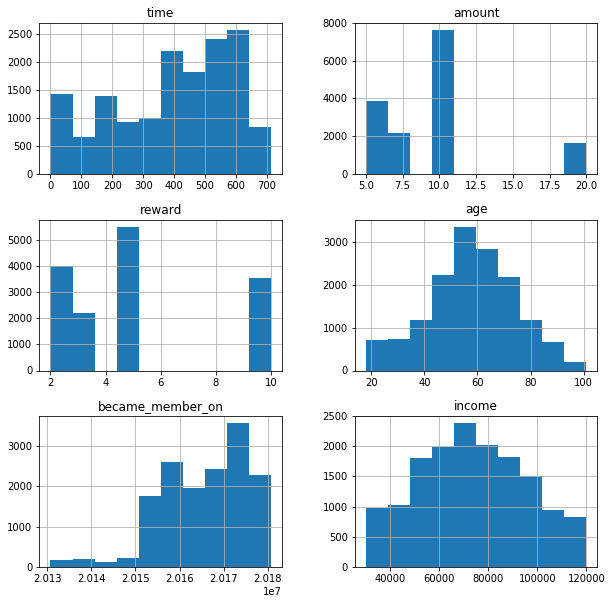

In [48]:
train_data = merge_df
train_data[(train_data['gender']=='F') & (train_data['event']=='offer completed')].hist(figsize=(10,10));

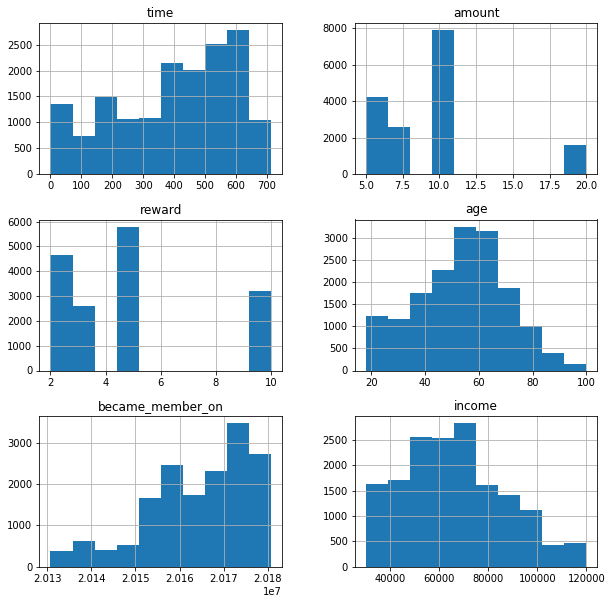

In [49]:
train_data[(train_data['gender']=='M') & (train_data['event']=='offer completed')].hist(figsize=(10,10));

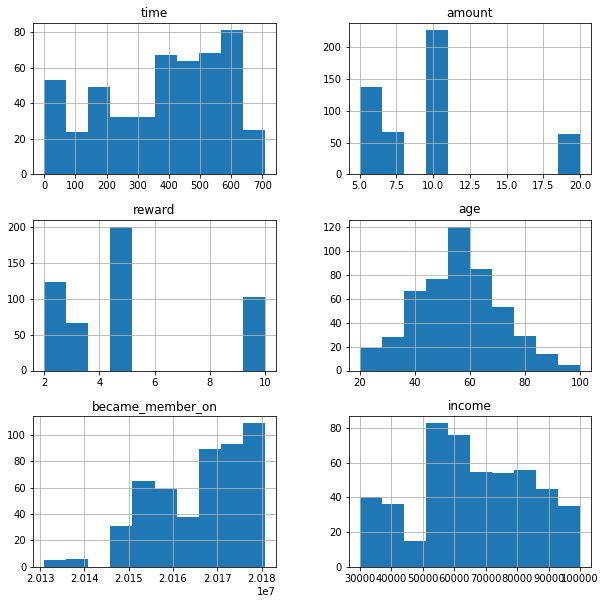

In [50]:
train_data[(train_data['gender']=='O') & (train_data['event']=='offer completed')].hist(figsize=(10,10));

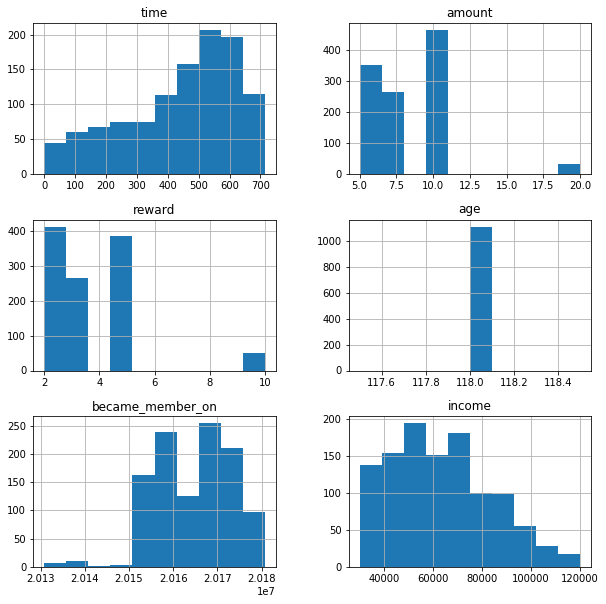

In [51]:

train_data[(train_data['gender']=='Unknown') & (train_data['event']=='offer completed')].hist(figsize=(10,10));

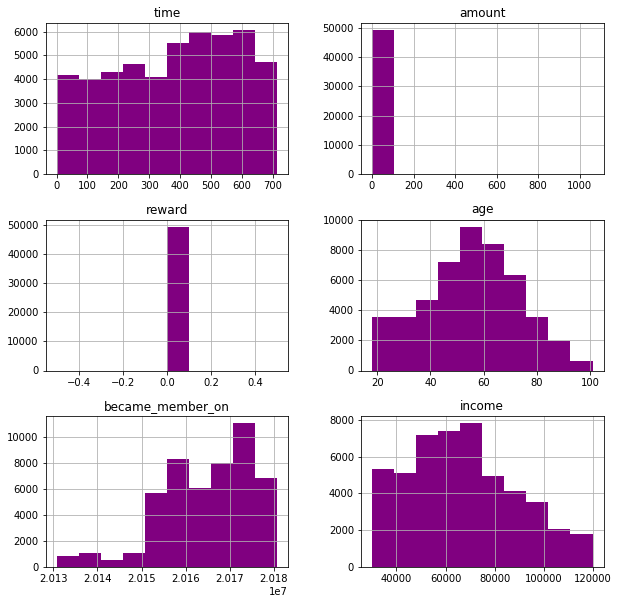

In [52]:
train_data[(train_data['gender']=='F') & (train_data['event']=='transaction')].hist(figsize=(10,10), color = "purple");

In [53]:
train_data.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

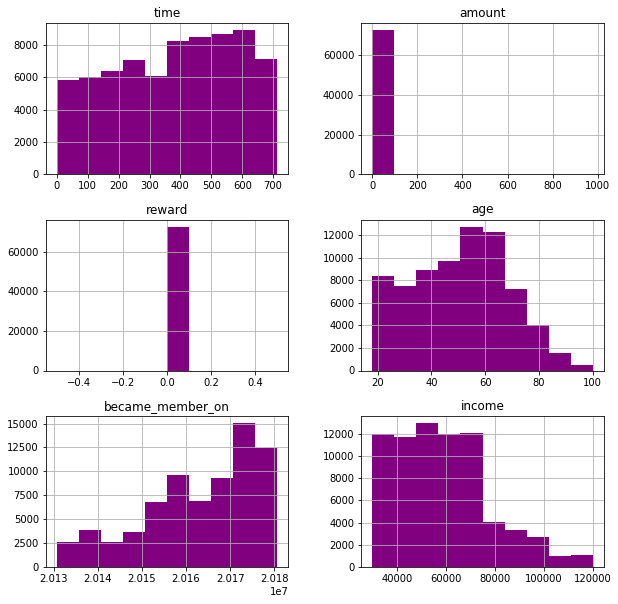

In [54]:
train_data[(train_data['gender']=='M') & (train_data['event']=='transaction')].hist(figsize=(10,10), color = "purple");

In [59]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
seed =7

In [67]:
train_data["gender"].dtype

dtype('O')

In [68]:
X = train_data[["gender","age", "event", "reward", "time"]]
Y = train_data["amount"]
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state=42)

In [69]:
#https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

ValueError: could not convert string to float: 'offer completed'